# Project 2: Credit Risk and Statistical Learning

**Names of all group members:**
- Firstname Lastname (email@example.com)
- Firstname Lastname (email@example.com)


---

All code below is only suggestive and you may as well use different approaches.

In [16]:
# Exercise 1.
import numpy as np
np.random.seed(0)  # for reproducibility

m, n = 20000, 10000
rng = np.random.default_rng(0)

# simulate explanatory variables x
x1 = rng.uniform(18, 80, size=m + n)
x2 = rng.uniform(1, 15, size=m + n)  # kCHF/month
x3 = rng.binomial(1, 0.1, size=m + n)

X = np.column_stack((x1, x2, x3))
X_train, X_test = X[:m], X[m:]


# a) calculate empirical means and standard deviations over training data
train_means = X_train.mean(axis=0)
train_stds = X_train.std(axis=0)

features = ["age", "income", "employement status"]
for label, mean, std in zip(features, train_means, train_stds):
    print(f"{label:>14}: mean={mean:6.3f}, std={std:6.3f}")


# b) Suggest other variables that would realistically be relevant in credit scoring.
# (you do not have to implement those of course, just explain your answer in writing)


           age: mean=49.162, std=17.836
        income: mean= 8.001, std= 4.051
employement status: mean= 0.098, std= 0.297


## 1b: Additional variables for credit scoring
- Credit history length (e.g., oldest account age) and recent delinquencies/charge-offs.
- Debt-to-income ratio and current outstanding revolving utilization.
- Existing loan obligations (e.g., mortgages, auto/student loans) and payment history.
- Collateral or security on the loan (secured vs. unsecured) and loan-to-value ratio.
- Loan purpose, requested amount, and relationship tenure with the lender.

In [17]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))
p1 = lambda X: sigmoid(13.3 - 0.33 * X[:, 0] + 3.5 * X[:, 1] - 3 * X[:, 2])

def p2(X):
    I = (X[:, 0] < 25) | (X[:, 0] > 75)
    return sigmoid(5 - 10 * I + 1.1 * X[:, 1] - X[:, 2])

rng_ksi = np.random.default_rng(1)

# build the first dataset
ksi1 = rng_ksi.uniform(size=m + n)
prob1_all = p1(X)
y1 = (ksi1 <= prob1_all).astype(int)

y1_train, y1_test = y1[:m], y1[m:]

# build the second dataset
ksi2 = rng_ksi.uniform(size=m + n)
prob2_all = p2(X)
y2 = (ksi2 <= prob2_all).astype(int)

y2_train, y2_test = y2[:m], y2[m:]



In [18]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)

# Fit the models on both datasets
model1 = LogisticRegression().fit(X_train, y1_train)
model2 = LogisticRegression().fit(X_train, y2_train)

pred_X_train1 = model1.predict_proba(X_train)
pred_X_test1 = model1.predict_proba(X_test)
pred_X_train2 = model2.predict_proba(X_train)
pred_X_test2 = model2.predict_proba(X_test)

# Calculate cross-entropy loss on both datasets for train and test
loss_train1 = log_loss(y1_train, pred_X_train1)
loss_test1 = log_loss(y1_test, pred_X_test1)
loss_train2 = log_loss(y2_train, pred_X_train2)
loss_test2 = log_loss(y2_test, pred_X_test2)

print(f"Logistic regression (dataset 1): train CE={loss_train1:.4f}, test CE={loss_test1:.4f}")
print(f"Logistic regression (dataset 2): train CE={loss_train2:.4f}, test CE={loss_test2:.4f}")


Logistic regression (dataset 1): train CE=0.0351, test CE=0.0297
Logistic regression (dataset 2): train CE=0.1479, test CE=0.1510


In [19]:
# Exercise 2.b)
# Calculate normalized data (scale by training std only, no centering)

if np.any(train_stds == 0):
    raise ValueError("Encountered zero std in training data for standardization.")

X_train_std = X_train / train_stds
X_test_std = X_test / train_stds


In [20]:
# Exercise 2.b)
from sklearn.svm import SVC
# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)
svm1 = SVC(kernel='rbf', gamma=10.0, C=0.2, probability=True)
svm2 = SVC(kernel='rbf', gamma=10.0, C=0.2, probability=True)

svm1.fit(X_train_std, y1_train)
svm2.fit(X_train_std, y2_train)



SVC(C=0.2, gamma=10.0, probability=True)

In [21]:
# Exercise 2.b)
# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))

pred_X_train1_svm = svm1.predict_proba(X_train_std)
pred_X_test1_svm = svm1.predict_proba(X_test_std)
pred_X_train2_svm = svm2.predict_proba(X_train_std)
pred_X_test2_svm = svm2.predict_proba(X_test_std)

# Calculate cross-entropy loss on both datasets for train and test

loss_train1_svm = log_loss(y1_train, pred_X_train1_svm)
loss_test1_svm = log_loss(y1_test, pred_X_test1_svm)
loss_train2_svm = log_loss(y2_train, pred_X_train2_svm)
loss_test2_svm = log_loss(y2_test, pred_X_test2_svm)

print(f"SVM (dataset 1): train CE={loss_train1_svm:.4f}, test CE={loss_test1_svm:.4f}")
print(f"SVM (dataset 2): train CE={loss_train2_svm:.4f}, test CE={loss_test2_svm:.4f}")


SVM (dataset 1): train CE=0.0596, test CE=0.0478
SVM (dataset 2): train CE=0.0772, test CE=0.0830


In [22]:
# Exercise 2.c)
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)

def roc_points(y_true, prob_pos, thresholds):
    tpr, fpr = [], []
    for t in thresholds:
        pred_pos = prob_pos >= t
        tp = ((pred_pos == 1) & (y_true == 1)).sum()
        fp = ((pred_pos == 1) & (y_true == 0)).sum()
        fn = ((pred_pos == 0) & (y_true == 1)).sum()
        tn = ((pred_pos == 0) & (y_true == 0)).sum()
        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0.0)
    return np.array(fpr), np.array(tpr)


def auc_riemann(fpr, tpr):
    order = np.argsort(fpr)
    fpr_sorted = fpr[order]
    tpr_sorted = tpr[order]
    return np.sum((tpr_sorted[:-1] + tpr_sorted[1:]) * np.diff(fpr_sorted) / 2)


# first data set & logistic regression:
# (the code should be reusable for all cases, only exchanging datasets and predicted probabilities depending on the model)


# Compute and plot the ROC and AUC cruves


# second data set & logistic regression:


# first data set and SVM:


# second data set and SVM:

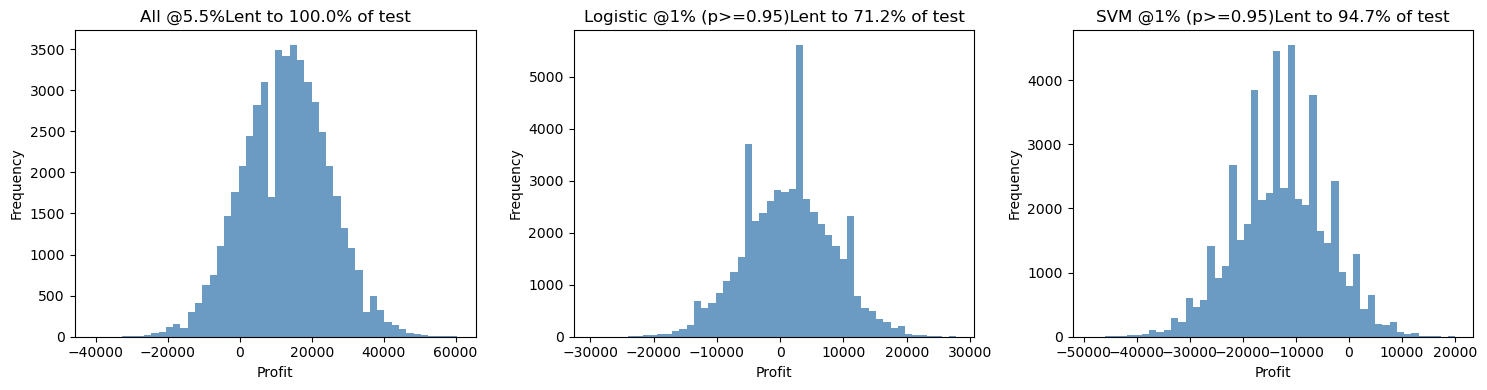

All @5.5%: lend frac=100.00% | E[profit]=12855.82, VaR95=-7040.00, ES95=-11740.61
Logistic @1% (p>=0.95): lend frac=71.25% | E[profit]=1413.91, VaR95=-10560.00, ES95=-13040.74
SVM @1% (p>=0.95): lend frac=94.74% | E[profit]=-12748.95, VaR95=-27470.00, ES95=-30736.35


In [ ]:
# Exercise 3.

# Set model parameters and define matrix D
num_scenarios = 50000
loan_amount = 1000
rng_scen = np.random.default_rng(3)

# Focus on dataset 2 (test set)
probs = prob2_all[m:]

def simulate_profits(mask, rate):
    # mask: boolean vector indicating loans we issue on test set
    # rate: interest rate (e.g., 0.055)
    profits = []
    chunk = 500  # limits memory to ~5M draws per chunk
    for start in range(0, num_scenarios, chunk):
        end = min(start + chunk, num_scenarios)
        size = end - start
        draws = rng_scen.random((size, probs.shape[0])) <= probs  # repayments
        repay_counts = (draws & mask).sum(axis=1)
        default_counts = ((~draws) & mask).sum(axis=1)
        # profit: interest on repaid loans minus full loss on defaults (principal not recovered)
        profit_chunk = repay_counts * loan_amount * rate - default_counts * loan_amount
        profits.append(profit_chunk)
    return np.concatenate(profits)

# Scenario 1 (all lend, 5.5%)
mask_all = np.ones_like(probs, dtype=bool)
profits_all = simulate_profits(mask_all, 0.055)

# Scenario 2 (selective, 1%, logistic regression selection)
mask_log = pred_X_test2[:, 1] >= 0.95
profits_log = simulate_profits(mask_log, 0.01)

# Scenario 3 (selective, 1%, SVM selection)
mask_svm = pred_X_test2_svm[:, 1] >= 0.95
profits_svm = simulate_profits(mask_svm, 0.01)

scenario_data = [
    ("All 5.5% rate", profits_all, mask_all.mean()),
    ("Logistic 1% rate(p>=0.95)", profits_log, mask_log.mean()),
    ("SVM @1% rate(p>=0.95)", profits_svm, mask_svm.mean()),
]

# Plot the histogram of profits and losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (title, profits, frac_lent) in zip(axes, scenario_data):
    ax.hist(profits, bins=50, color='steelblue', alpha=0.8)
    ax.set_title(f"{title}Lent to {frac_lent*100:.1f}% of test")
    ax.set_xlabel("Profit")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# Calculate expected profit and losses, compute 95%-VaR and 95%-ES
for title, profits, frac_lent in scenario_data:
    exp_profit = profits.mean()
    var95 = np.percentile(profits, 5)
    es95 = profits[profits <= var95].mean()
    print(f"{title}: lend frac={frac_lent*100:.2f}% | E[profit]={exp_profit:.2f}, VaR95={var95:.2f}, ES95={es95:.2f}")
